# Genshin Impact Lore Hybrid QA System with Knowledge Graph + RAG + BM25

This notebook demonstrates a hybrid QA (Question Answering) system that combines:
- Neo4j knowledge graph (structured relationships)
- RAG (Retrieval-Augmented Generation) using Gemini Embeddings + Chroma
- BM25 sparse retrieval using keyword matching

All data is extracted from the **[Genshin Impact Archon Quest Wiki](https://genshin-impact.fandom.com/wiki/Archon_Quest)


---

### Technologies Used

- **Gemini 1.5 Pro** – for rewriting, decomposing, expanding, summarizing
- **LangChain** – for prompt templates, document handling, retrievers
- **Neo4j** – stores the structured knowledge graph
- **Chroma** – stores vector embeddings for narrative-based RAG
- **BM25Retriever** – indexes full-text wiki content for keyword-based fallback search

---

### Example Use Case

**Query**: `"what's paimon's deal with zhongli?"`

**System Actions**:
1. Rewrites the query for clarity
2. Decomposes it into simpler sub-questions
3. Expands those queries into 15–20 variations
4. Retrieves relevant information from:
   - KG (via Cypher query in Neo4j)
   - RAG (semantic search over chunked narrative)
   - BM25 (keyword-based match from raw text)
5. Synthesizes the final story using Gemini in formal narrative style

**Output**: A complete, grounded lore summary using only retrieved facts

---

## 🔐 Environment Setup

We use `.env` to load sensitive API keys and connection strings securely.

In [3]:
# 1️. Load Environment Variables
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

# Get credentials from .env
API_KEY = os.getenv("GOOGLE_API_KEY")
NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USER = os.getenv("NEO4J_USER")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

# Quick checks
assert API_KEY, "Missing GOOGLE_API_KEY!"
assert NEO4J_URI, "Missing NEO4J_URI!"

####  匯入模組

In [285]:
import sys
sys.path.append("src")  # 加入 scripts 資料夾到 Python 路徑
#  匯入模組
from data_extraction    import fetch_wiki_text, fetch_multiple_wiki_texts
from triple_extraction  import generate_triples_batched
from kg_builder         import build_graph, export_graphml, crawl_and_write_csv
from rag_builder        import build_rag_vectorstore, GeminiEmbeddings
from bm25_builder       import build_bm25_retriever_from_txt
from qa_pipeline        import init_gemini_llm, build_kg_qa_chain, run_kg_qa, run_multi_source_qa
from utils              import rewrite_query_for_search, decompose_query, expand_query_with_llm, pick_diverse_queries, classify_intent_llm

## Step 1: Web Scraping & Data Extraction

We start by scraping story content from the Genshin Impact Archon Quest Wiki using `requests` and `BeautifulSoup`.  
The extracted text will be used to generate knowledge triples and semantic chunks for downstream QA tasks.

📌 Example page:  
[The Outlander Who Caught the Wind](https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind)


In [17]:
# Example URL
urls = [
    "https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind",
]

# Preview the extracted text
text = fetch_wiki_text(urls[0])
print(text[:1000])  # Print only first 1000 characters for readability


The Outlander Who Caught the WindMondstadt's Quest ActQuest TypeChapterArchonPrologueActIPreviousNextN/AFor a Tomorrow Without TearsRequirementsArchon QuestRequirement(s)Wanderer's TrailRewards100The Outlander Who Caught the Windis the first act in theProloguechapter of theArchon Quests.
In conjunction with theArchon QuestWanderer's Trail, it serves as a tutorial level for movement and combat, and introduces some of the main characters.
During their travels across the worlds, theTravelerand theirtwin siblingare confronted by anunknown entityas they were about to depart. In the ensuing battle, the unknown entity seals off the sibling, before doing the same to the Traveler, sealing their powers and putting both of them in Teyvat.
The Traveler eventually wakes up after an undisclosed amount of time and proceeds to wander across Teyvat. The Traveler is aroundCape Oathwhen they fish outPaimonfrom the sea, thus saving her from drowning. Grateful for the rescue, Paimon becomes their travel co

## Step 2: Build Knowledge Graph (Triples)

In this step, we convert raw story paragraphs from the Genshin Impact Wiki into a structured Knowledge Graph by extracting semantic triples. Each triple represents a fact in the form of: (subject, relation, object)


We use the **Gemini API** to extract these triples based on a restricted schema (e.g., `knows`, `from`, `participates_in`, etc.).  
These triples form the basis of a **Genshin Impact Knowledge Graph**, which we visualize using `networkx`.


##### Objective: 
To extract structured knowledge such as:
- Characters and their relationships (e.g., Traveler knows Paimon)
- Events and their participants (e.g., Traveler participates_in Stormterror Incident)
- Locations of events (e.g., Stormterror Incident occurs_in Mondstadt)


##### Example source:  
[The Outlander Who Caught the Wind](https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind)

In [21]:
# Load your Gemini API key from the environment
client = genai.Client(api_key=API_KEY)

# Example usage
urls = [
    "https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind"
]
full_text = fetch_multiple_wiki_texts(urls)
triples = generate_triples_batched(full_text, client)

for t in triples:
    print(f"({t.subject}, {t.relation}, {t.object})")


(The Outlander Who Caught the Wind, isActOf, Prologue)
(The Outlander Who Caught the Wind, isActOf, Archon Quests)
(The Outlander Who Caught the Wind, isAlsoKnownAs, tutorial level)
(The Outlander Who Caught the Wind, introduces, main characters)
(unknown entity, seals, Traveler's sibling)
(unknown entity, seals, Traveler)
(unknown entity, puts, Traveler and sibling in Teyvat)
(Traveler, fishes, Paimon)
(Paimon, becomes, travel companion)
(Paimon, becomes, guide)
(Paimon, suggests, contact The Seven)
(Traveler, touches, Anemo Statue of The Seven)
(Traveler, spots, green dragon)
(Traveler and Paimon, pursue, green dragon)
(stranger, calms, green dragon)
(Traveler, alerts, dragon)
(stranger, leaves, crimson teardrop crystal)
(Traveler, takes, crimson teardrop crystal)
(Amber, is, Outrider of the Knights of Favonius)
(Amber, escorts, Traveler and Paimon to Mondstadt)
(Traveler and Paimon, assist, Amber)
(Amber, gifts, Wind Glider)
(Stormterror, rampages, region)
(Stormterror, unleashes, w

## Step 3: Visualize & Explore the Knowledge Graph

In this step, we visualize the structured triples as a directed knowledge graph using NetworkX.
Each triple (subject, relation, object) becomes a labeled edge between nodes.

#### 3.1 Visualize the Graph

None


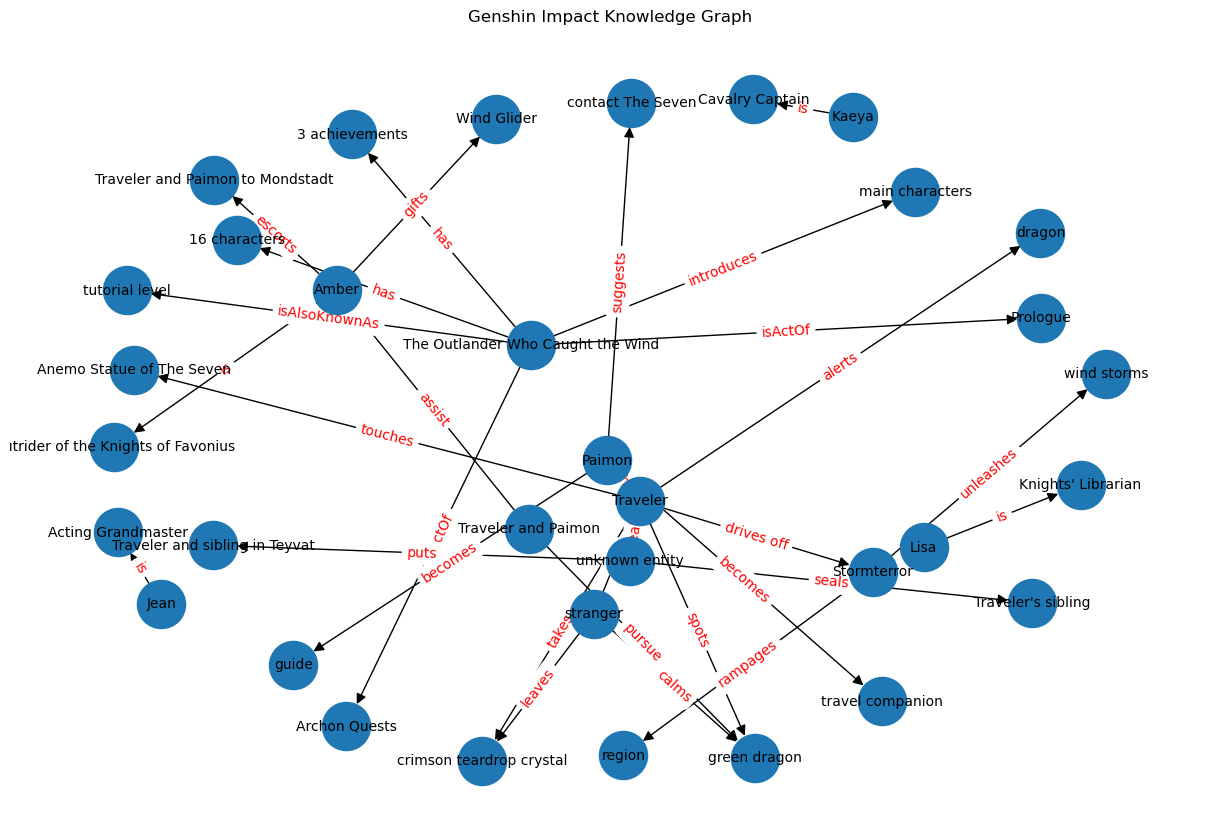

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

G = build_graph(triples)
message = export_graphml(G, "genshin_story_kg.graphml")
print(message)

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1200, font_size=10, arrowsize=15)

# Show relation labels on edges
edge_labels = nx.get_edge_attributes(G, "relation")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.title("Genshin Impact Knowledge Graph")
plt.axis("off")
plt.show()

#### 3.2 Load & Query the Graph

You can later reload the exported .graphml file for further querying or debugging.

In [261]:
# Load from file
G = nx.read_graphml("genshin_story_kg.graphml")

# Basic stats
print(f"🧠 Nodes: {len(G.nodes)}")
print(f"🔗 Edges: {len(G.edges)}")


🧠 Nodes: 34
🔗 Edges: 31


#### 3.3 Example Query: Find Relations Involving "Paimon"

Let’s explore all edges where "Paimon" is either the subject or object:

In [60]:
paimon_relations = []
for u, v, data in G.edges(data=True):
    if 'paimon' in u.lower() or 'paimon' in v.lower():
        rel = data.get('relation', 'RELATED_TO')
        paimon_relations.append((u, rel, v))

# Display results
for head, rel, tail in paimon_relations:
    print(f"{head} --[{rel}]--> {tail}")


Traveler --[fishes]--> Paimon
Paimon --[becomes]--> travel companion
Paimon --[becomes]--> guide
Paimon --[suggests]--> contact The Seven
Traveler and Paimon --[pursue]--> green dragon
Traveler and Paimon --[assist]--> Amber
Amber --[escorts]--> Traveler and Paimon to Mondstadt


#### Summary
This process enables:
- Visualizing lore relationships from wiki text as a graph
- Exporting the graph to standard formats (e.g., .graphml)
- Querying character connections, such as finding which events "Paimon" participates in

## Step 4: Knowledge Graph Construction & CSV Export

In this step, we extract structured triples from Genshin Impact's *Archon Quest* wiki pages using Gemini API, and export them as CSV files for graph database use (e.g., Neo4j).

### Workflow
1. Fetch all Archon Quest URLs from the Genshin Wiki.
2. Extract story content from each page.
3. Generate (subject, relation, object) triples via Gemini.
4. Save:
   - `all_acts_nodes.csv` → unique entities (nodes)
   - `all_acts_edges.csv` → relationships (edges)

### Sample Triple Output
| Subject     | Relation         | Object         |
| ----------- | ---------------- | -------------- |
| Traveler    | participates_in  | Prologue Act I |
| Stormterror | occurs_in        | Mondstadt      |
| Venti       | knows            | Traveler       |

These files are ready to be imported into Neo4j for semantic retrieval.

In [105]:

# Main pipeline: Extract, generate triples, and save as CSV 
urls = fetch_act_urls()

crawl_and_write_csv(urls, "all_acts_nodes.csv", "all_acts_edges.csv")


🔍 Processing: https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind
🔍 Processing: https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears
🔍 Processing: https://genshin-impact.fandom.com/wiki/Adventure_Rank
🔍 Processing: https://genshin-impact.fandom.com/wiki/Song_of_the_Dragon_and_Freedom
🔍 Processing: https://genshin-impact.fandom.com/wiki/Of_the_Land_Amidst_Monoliths
🔍 Processing: https://genshin-impact.fandom.com/wiki/Farewell,_Archaic_Lord
🔍 Processing: https://genshin-impact.fandom.com/wiki/A_New_Star_Approaches
🔍 Processing: https://genshin-impact.fandom.com/wiki/Bough_Keeper:_Dainsleif
🔍 Processing: https://genshin-impact.fandom.com/wiki/We_Will_Be_Reunited
🔍 Processing: https://genshin-impact.fandom.com/wiki/Lupus_Minor_Chapter
🔍 Processing: https://genshin-impact.fandom.com/wiki/The_Meaning_of_Lupical
🔍 Processing: https://genshin-impact.fandom.com/wiki/Autumn_Winds,_Scarlet_Leaves
🔍 Processing: https://genshin-impact.fandom.com/wiki/The_Immovabl

## Step 5: Import CSV into Neo4j (Manual Upload)

Manually upload the generated knowledge graph CSV files into **Neo4j** to create a retrievable semantic graph for downstream question-answering and visualization tasks.

---

#### Files to Upload  
After completing **Step 4**, you should have the following two files:

- `all_acts_nodes.csv` – contains all **entities** (e.g., characters, items, events, locations)  
- `all_acts_edges.csv` – contains all **semantic relationships** (triples) between those entities

---

#### Upload Instructions  

1. Open **Neo4j Desktop** or go to the **Neo4j Web Interface** (e.g., `http://localhost:7474`)
2. Navigate to your project’s **Import** folder:
   - Click `Manage` → `Open Folder` → `Import`
3. Copy or move the following files into that `Import` folder:
   - `all_acts_nodes.csv`
   - `all_acts_edges.csv`

Once uploaded, you're ready to run Cypher commands to import the data into Neo4j as nodes and relationships.

---

#### 📺 Highly Recommended Tutorial  
If you're unfamiliar with how to import CSV files into Neo4j, this video was extremely helpful and easy to follow:

 **How to Upload a CSV file to a GRAPH database for FREE (Neo4j AuraDB)**  
 https://www.youtube.com/watch?v=lLx1BHdZY-o  
 Special thanks to the creator — this tutorial helped me a lot!


 

## Step 6: Question Answering with LangChain + Neo4j (GraphCypherQAChain)
Use a **LangChain-powered GraphQA pipeline** to perform semantic question answering over the knowledge graph stored in Neo4j. This allows us to transform natural language questions into **Cypher queries**, fetch structured results, and generate human-readable answers using an LLM.

---

#### What This Step Does

| Component           | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
|  **LLM (Gemini)** | Interprets both questions and structured query outputs for natural answers  |
|  **Neo4j Graph**  | Connects to the hosted Neo4j database containing our structured triples     |
|  **Prompt Templates** | Defines how to translate natural language into Cypher, and how to summarize query results |
|  **GraphCypherQAChain** | Combines LLM + Neo4j into an end-to-end QA chain                         |

---

#### Example Use Case

**Input question:**  
> _"Who knows Traveler?"_

**System output includes:**  
- The generated **Cypher query**
- The **raw results** from Neo4j
- The **structured answer** summarized by Gemini

---

####  Prerequisites

Before using this step:
- You must have successfully uploaded your CSV data into Neo4j (Step 5).
- Your Neo4j database must be accessible via the correct `url`, `username`, and `password`.
- The `relation` type should be used for all edges, and actual meanings must be stored in `relation` property.

---

This setup enables powerful semantic exploration of your Genshin knowledge graph via natural language!


In [141]:
# Run QA
result = run_kg_qa(
    query="who knows Traveler?",
    entity_id="Traveler",
    api_key=API_KEY,
    neo4j_uri=NEO4J_URI,
    neo4j_user=NEO4J_USER,
    neo4j_password=NEO4J_PASSWORD
)

# Output
print("\n=== Cypher Query ===")
print(result["query"])

print("\n=== Raw Records ===")
print(result["result"])

print("\n=== Summary ===")
print(result["result"])




> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (a:Entity)-[r:relation]->(b:Entity {id:"Traveler"})
WHERE r.relation =~ "(?i).*know.*" OR r.relation =~ "(?i).*knows.*"
RETURN r.relation AS relation_type, a.id AS node

Full Context:
[{'relation_type': 'knows', 'node': 'green dragon'}, {'relation_type': 'knows', 'node': 'stranger'}, {'relation_type': 'knows', 'node': 'Amber'}, {'relation_type': 'knows', 'node': 'Katheryne'}, {'relation_type': 'knows', 'node': 'Barbara'}]

> Finished chain.

=== Cypher Query ===
who knows Traveler?

=== Raw Records ===
```json
{
  "knows": ["green dragon", "stranger", "Amber", "Katheryne", "Barbara"]
}
```

=== Summary ===
```json
{
  "knows": ["green dragon", "stranger", "Amber", "Katheryne", "Barbara"]
}
```


## Step 7: Create RAG Vector Store from Genshin Wiki (Archon Quest)

Transform all **Archon Quest** content from the Genshin Wiki into chunked documents, embed them using the **Gemini API**, and store them in a **Chroma** vector database for use in RAG (Retrieval-Augmented Generation).

---

### Workflow Overview

| Stage                        | Description                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **URL Collection**        | Scrape all Archon Quest page links from the Genshin Wiki.                  |
| **Text Extraction**       | Parse paragraphs and their associated headings (`<h2>`, `<h3>`) as context.|
| **Chunking**              | Split long texts into overlapping segments while preserving section titles.|
| **Embedding (Gemini)**    | Use Google Gemini's embedding API to vectorize each document chunk.        |
| **Vector Store (Chroma)** | Store all embedded chunks and metadata in a local Chroma vector DB.        |




In [177]:
vectorstore = build_rag_vectorstore()

✅ Total unique document chunks: 381
✅ Vector store saved to ./genshin_chroma


#### Query the Vector Store (Quick Test)

This step verifies that our Chroma-based vector store is working correctly by checking the number of documents it contains and performing a basic semantic query.


In [181]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
query = "What is the relationship between the Traveler and Nahida in Sumeru?"
results = retriever.get_relevant_documents(query)

print("\n📝 Top relevant chunks:")

for doc in results:
    print(f"- Source: {doc.metadata['source']}｜chunk {doc.metadata['chunk_index']}")
    print(f"  Content: {doc.page_content[:500]}...\n")



📝 Top relevant chunks:
- Source: https://genshin-impact.fandom.com/wiki/Akasha_Pulses,_the_Kalpa_Flame_Rises｜chunk 0
  Content: ### Summary[]
Heading into the Sanctuary, the Traveler and Paimon meet Nahida in person for the first time. Nahida apologizes for putting them through situations she caused, but they decline the apology as she wasn't at fault. Now knowing the full extent of the damage, Nahida reverts the Akasha to be used by herself only and revoke all of the sages' access, make them pay for their crimes, and also to stop the false god. She advises them to prepare themselves....

- Source: https://genshin-impact.fandom.com/wiki/Dreams,_Emptiness,_Deception｜chunk 1
  Content: Nahida takes them to the marketplace where she talks withNabiya,AkimandQishanas Katheryne, while the Traveler learns how they speak and act. The following day, as Setaria prepares to shop on her regular day off, Nahida tells the Traveler that because she still has trouble with human behavior, they'll be t

##  Step 8: Build BM25 Retriever for Local Keyword-Based Search

Use the classic **BM25 ranking algorithm** to retrieve relevant chunks from the Archon Quest text based on keyword overlap.  
This provides a lightweight alternative to dense vector retrieval for text-based search.

---

###  What This Step Does

| Stage              | Description                                                                 |
| ------------------ | --------------------------------------------------------------------------- |
|  **Text Loading** | Reads raw story text from `archon_quests.txt`                              |
|  **Chunking**     | Splits the full text into overlapping chunks to preserve context           |
|  **Documents**    | Wraps each chunk into a LangChain `Document` format for indexing            |
|  **BM25 Indexing**| Uses `BM25Retriever` to enable lexical keyword search on the document chunks |

---


#### Crawl Archon Quest Pages & Save as Plain Text
This step scrapes all Archon Quest story pages from the Genshin Impact Wiki and stores the raw paragraph text into a `.txt` file.

In [189]:
# Step 1: Fetch all Archon Quest page URLs from the Genshin Impact Wiki

save_all_archon_quests_to_txt("archon_quests.txt")

Found 42 Archon Quest URLs
 (1/42) Fetching: https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind
 (2/42) Fetching: https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears
 (3/42) Fetching: https://genshin-impact.fandom.com/wiki/Adventure_Rank
 (4/42) Fetching: https://genshin-impact.fandom.com/wiki/Song_of_the_Dragon_and_Freedom
 (5/42) Fetching: https://genshin-impact.fandom.com/wiki/Of_the_Land_Amidst_Monoliths
 (6/42) Fetching: https://genshin-impact.fandom.com/wiki/Farewell,_Archaic_Lord
 (7/42) Fetching: https://genshin-impact.fandom.com/wiki/A_New_Star_Approaches
 (8/42) Fetching: https://genshin-impact.fandom.com/wiki/Bough_Keeper:_Dainsleif
 (9/42) Fetching: https://genshin-impact.fandom.com/wiki/We_Will_Be_Reunited
 (10/42) Fetching: https://genshin-impact.fandom.com/wiki/Lupus_Minor_Chapter
 (11/42) Fetching: https://genshin-impact.fandom.com/wiki/The_Meaning_of_Lupical
 (12/42) Fetching: https://genshin-impact.fandom.com/wiki/Autumn_Winds,_Sc

In [199]:
# --- BM25 Retriever Setup for Keyword-Based Search ---

bm25 = build_bm25_retriever_from_txt("archon_quests.txt", k=3)

query = "Who is Paimon?"
results = bm25.get_relevant_documents(query)

print("📝 Top matching chunks:\n")
for doc in results:
    print(f"🔹 {doc.metadata['source']}")
    print(doc.page_content[:300] + "...\n")


📝 Top matching chunks:

🔹 chunk_0
=== https://genshin-impact.fandom.com/wiki/The_Outlander_Who_Caught_the_Wind ===
The Outlander Who Caught the WindMondstadt's Quest ActQuest TypeChapterArchonPrologueActIPreviousNextN/AFor a Tomorrow Without TearsRequirementsArchon QuestRequirement(s)Wanderer's TrailRewards100The Outlander Who Caugh...

🔹 chunk_7
After dealing with the temples, Paimon suggests that they return to the knights' headquarters to see what they should do next.
16Charactersappear in this Act:
There are3Achievementsobtainable fromThe Outlander Who Caught the Wind:...

🔹 chunk_8
=== https://genshin-impact.fandom.com/wiki/For_a_Tomorrow_Without_Tears ===
For a Tomorrow Without TearsMondstadt's Quest ActQuest TypeChapterArchonPrologueActIIPreviousNextThe Outlander Who Caught the WindSong of the Dragon and FreedomRequirementsAdventure RankRequired10Rewards100For a Tomorrow Wit...



## Step 9: Multi-Source Question Answering with KG + RAG + BM25  
Answer user questions about *Genshin Impact* lore by combining results from:
- **Knowledge Graph (KG)** via Cypher QA
- **Semantic Retrieval (RAG)** using Gemini embeddings + Chroma
- **Lexical Retrieval (BM25)** using keyword-based search

This hybrid approach ensures broad coverage and rich narrative context, even for complex or ambiguous queries.

---

### What This Step Does

| Stage                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| Query Rewriting      | Reformulates informal or vague questions into clearer search-oriented input |
| Intent Classification | Detects the type of question: character, event, quest, location, or general |
| Query Decomposition  | Breaks complex queries into simpler sub-questions                            |
| Query Expansion       | Paraphrases and augments queries to improve retrieval diversity              |
| Multi-Source Retrieval | Queries **KG**, **RAG**, and **BM25** independently for relevant chunks     |
| Final Answer Generation | Uses Gemini to summarize results into a cohesive, lore-accurate answer    |





In [293]:
query = "what's paimon's deal with zhongli?"
entity_id = "Paimon"

bm25 = build_bm25_retriever_from_txt("archon_quests.txt")
embedding = GeminiEmbeddings()

answer = run_multi_source_qa(
    query=query,
    entity_id=entity_id,
    chain=chain,
    vectorstore=vectorstore,
    bm25_retriever=bm25,
    embedding_model=embedding
)

print("\n🧠 Final Answer:\n", answer)


📥 Original Query: what's paimon's deal with zhongli?
📝 Rewritten Query:
 "Relationship between Paimon and Zhongli in Genshin Impact" 

or

"Paimon and Zhongli interactions explained Genshin Impact"

or

"Nature of Paimon and Zhongli's connection in Genshin Impact"
🔍 Classified Intent:
 character_relationship
🧩 Sub-Queries:
  - What is Paimon's role in relation to Zhongli's story in Genshin Impact?
  - How do Paimon and Zhongli interact with each other in Genshin Impact?
  - Does Zhongli show any particular awareness or knowledge of Paimon's true nature in Genshin Impact?


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH p = (a:Entity {id:"Paimon"})-[*..5]-(b:Entity)
WHERE b.id =~ "(?i).*rex lapis.*" OR b.id =~ "(?i).*morax.*" OR b.id =~ "(?i).*zhongli.*"
WITH relationships(p) AS rels
UNWIND rels AS r
WITH r, endNode(r) AS b
RETURN r.relation AS relation_type, b.id AS node

Full Context:
[{'relation_type': 'knows', 'node': 'Paimon'}, {'relation_type': 'knows', 